In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time

In [7]:
def calculate_first_n_legendre_polynomials(x: torch.Tensor, n: int) -> torch.Tensor:
    """
    Calcula los primeros n polinomios de Legendre en los puntos especificados.

    Entradas:
    x (torch.Tensor): Un tensor de PyTorch que contiene los puntos en los que se evaluarán los polinomios de Legendre.
    n (int): El grado del polinomio de Legendre más alto que se calculará.

    Salidas:
    (torch.Tensor): Un tensor de PyTorch que contiene los valores de los primeros n polinomios de Legendre en los puntos especificados.
    """

    # Inicializa los dos primeros polinomios de Legendre
    legendre_polynomials = [torch.ones_like(x), x]

    # Calcula los polinomios de Legendre hasta el grado n
    for i in range(2, n + 1):
        # Coeficientes para la relación de recurrencia de los polinomios de Legendre
        a = (2 * i - 1) / i
        b = (i - 1) / i

        # Calcula el polinomio de Legendre de grado i usando la relación de recurrencia
        legendre_polynomial = a * x * legendre_polynomials[-1] - b * legendre_polynomials[-2]

        # Añade el polinomio de Legendre de grado i a la lista
        legendre_polynomials.append(legendre_polynomial)

    # Devuelve los polinomios de Legendre como un tensor de PyTorch
    return torch.stack(legendre_polynomials, dim=1)

class OrthogonalNeuralNetwork(nn.Module):
    def __init__(self, n: int, lb: float, ub: float):
        """
        Inicializa una red neuronal ortogonal.

        Entradas:
        degree (int): El grado del polinomio de Legendre más alto que se utilizará en la red.
        """
        super(OrthogonalNeuralNetwork, self).__init__()
        self.n = n
        self.lb = lb
        self.ub = ub
        
        # Inicializa los coeficientes como parámetros del modelo que se aprenderán durante el entrenamiento
        self.weights = nn.Parameter(torch.zeros(n+1))
         

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Realiza una pasada hacia adelante a través de la red.

        Entradas:
        x (torch.Tensor): Un tensor de entrada.

        Salidas:
        (torch.Tensor): Un tensor de salida.
        """
        # Normaliza la entrada
        x = 2 * (x - self.lb) / (self.ub - self.lb) - 1

        # Calcula los polinomios de Legendre hasta el grado especificado
        legendre_polynomials = calculate_first_n_legendre_polynomials(x, self.n)

        # Selecciona los polinomios de Legendre necesarios para la aproximación
        selected_legendre_polynomials = legendre_polynomials[:, :self.n + 1]

        # Realiza una combinación lineal de los polinomios de Legendre seleccionados utilizando los coeficientes aprendidos
        return torch.matmul(selected_legendre_polynomials, self.weights[:self.n + 1])

El modelo tiene 201 parámetros.
Final Loss: 6.195806645514779e-10
Tiempo de entrenamiento: 0.1295461654663086 segundos


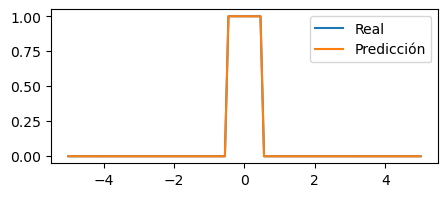

In [34]:
# Define el intervalo x
lb = -5
ub = 5
x = torch.tensor(np.linspace(lb, ub, 100), dtype=torch.float32)
def F(x):
    condition = torch.logical_and(x >= -0.5, x <= 0.5)
    y = torch.where(condition, torch.ones_like(x), torch.zeros_like(x))
    return y

y = F(x)

model = OrthogonalNeuralNetwork(200, lb, ub)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'El modelo tiene {num_params} parámetros.')

# Define la función de pérdida y el optimizador
criterion = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=1)

# Define una función de cierre que realizará el paso de avance y retroceso
def closure(model, optimizer, x, y):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    return loss

# Define una función para el entrenamiento que también imprime el tiempo de entrenamiento
def train_model(model, optimizer, closure, epochs, x, y):
    start_time = time.time()
    for epoch in range(epochs):  # número de épocas
        # Llama a step y pasa la función de cierre
        optimizer.step(lambda: closure(model, optimizer, x, y))
        
    # Calcula la pérdida final después de todas las épocas
    with torch.no_grad():
        y_pred = model(x)
        final_loss = criterion(y_pred, y)
        print(f'Final Loss: {final_loss.item()}')        
    end_time = time.time()
    print(f'Tiempo de entrenamiento: {end_time - start_time} segundos') 

# Entrena el modelo
train_model(model, optimizer, closure, 3, x, y)

# Predice los valores de y
with torch.no_grad():
    y_pred = model(x)
    
# Convierte los tensores a numpy arrays para la visualización
x = x.numpy()
y = y.numpy()
y_pred = y_pred.numpy()

# Crea la gráfica
plt.figure(figsize=(5, 2))
plt.plot(x, y, label='Real')
plt.plot(x, y_pred, label='Predicción')
plt.legend()
plt.show()

El modelo tiene 61 parámetros entrenables.
Entrenando la red neuronal...
Final Loss: 8.707612408898058e-08
Tiempo de entrenamiento: 3.2832577228546143 segundos


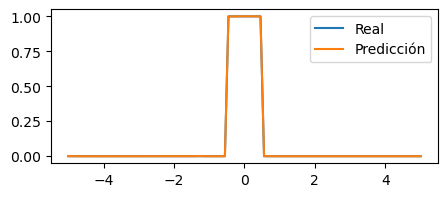

In [21]:
class Model(torch.nn.Module):
    def __init__(self, neurons, n_layers, activation=torch.tanh, lb=-5, ub=5):
        super(Model, self).__init__()
        self.activation = activation
        self.lb = lb
        self.ub = ub
        self.layers = torch.nn.ModuleList()
        self.layers.append(torch.nn.Linear(1, neurons))
        for _ in range(n_layers-2):
            self.layers.append(torch.nn.Linear(neurons, neurons))
        self.layers.append(torch.nn.Linear(neurons, 1))

    def forward(self, x):
        # Normaliza la entrada
        x = 2 * (x - self.lb) / (self.ub - self.lb) - 1
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x


# Define el intervalo x
lb = -5
ub = 5
x = torch.tensor(np.linspace(lb, ub, 100), dtype=torch.float32).view(-1, 1)
def F(x):
    condition = torch.logical_and(x >= -0.5, x <= 0.5)
    y = torch.where(condition, torch.ones_like(x), torch.zeros_like(x))
    return y

y = F(x)

# Define la red neuronal
model = Model(neurons=20, n_layers=2)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'El modelo tiene {num_params} parámetros entrenables.')

# Define la función de pérdida y el optimizador
criterion = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=1)

# Define una función de cierre que realizará el paso de avance y retroceso
def closure(model, optimizer, x, y):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    return loss

# Define una función para el entrenamiento que también imprime el tiempo de entrenamiento
def train_model(model, optimizer, closure, epochs, x, y):
    start_time = time.time()
    for epoch in range(epochs):  # número de épocas
        # Llama a step y pasa la función de cierre
        optimizer.step(lambda: closure(model, optimizer, x, y))
        
    # Calcula la pérdida final después de todas las épocas
    with torch.no_grad():
        y_pred = model(x)
        final_loss = criterion(y_pred, y)
        print(f'Final Loss: {final_loss.item()}')        
    end_time = time.time()
    print(f'Tiempo de entrenamiento: {end_time - start_time} segundos')
   

# Entrena el modelo
print("Entrenando la red neuronal...")
train_model(model, optimizer, closure, 1000, x, y)

# Predice los valores de y
with torch.no_grad():
    y_pred = model(x)

# Convierte los tensores a numpy arrays para la visualización
x = x.numpy()
y = y.numpy()
y_pred = y_pred.numpy()

# Crea la gráfica
plt.figure(figsize=(5, 2))
plt.plot(x, y, label='Real')
plt.plot(x, y_pred, label='Predicción')
plt.legend()
plt.show()